In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [3]:
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
tfb = tfp.bijectors
#                    

2022-12-22 21:00:41.722422: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-22 21:00:41.865107: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-12-22 21:00:41.895660: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-12-22 21:00:43.386436: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

In [4]:
sys.path.append('../src/')
sys.path.append('../scripts//')
import bbvi, polyakvi, mapp, hmc, modevi
import gaussianq
import diagnostics as dg
import pdbmodels

2022-12-22 21:00:46.971166: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-22 21:00:47.529557: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 21248 MB memory:  -> device: 0, name: Quadro RTX 6000, pci bus id: 0000:73:00.0, compute capability: 7.5


In [5]:
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [6]:


class FR_Gaussian_cov(tf.Module):

    def __init__(self, d, mu=0, scale=1, name=None, dtype=tf.float32):
        super(FR_Gaussian_cov, self).__init__(name=name)
        self.d = d
        self.loc = tf.Variable(tf.zeros(shape=[self.d], dtype=dtype) + mu, name='loc')
        self.cov = tf.Variable(tf.constant(np.identity(d), dtype=dtype), name='cov')
        self.noise = tfd.MultivariateNormalDiag(loc=tf.zeros(self.d))


    @property
    def q(self):
        """Variational distribution"""
        return tfd.MultivariateNormalFullCovariance(loc = self.loc, covariance_matrix= self.cov)


    def __call__(self, x):
        return self.log_prob(x)

    def log_prob(self, x):
        return self.q.log_prob(x)
    
    def log_likelihood(self, x):
        return self.q.log_prob(x)
    

    @tf.function
    def grad_log_likelihood(self, q):
        with tf.GradientTape() as tape:
            tape.watch(q)
            lp = self.log_prob(q)
        grad = tape.gradient(lp, q)
        return grad

    def sample(self, n=1, sample_shape=None):
        return self.q.sample(n)

    def forward(self, z):
        #x = self.loc + self.scale @ z                                                                                                                                                                                                                                                                                        
        #x = self.loc + tf.matmul(self.scale , z)                                                                                                                                                                                                                                                                             
        x = self.loc + tf.matmul(z, self.scale)
        return x

    def inverse(self, x):
        xm = (x - self.loc)
        #z = tf.linalg.inv(self.scale)@xm                                                                                                                                                                                                                                                                                     
        #z = tf.matmul(tf.linalg.inv(self.scale), xm)                                                                                                                                                                                                                                                                         
        z = tf.matmul(xm, tf.linalg.inv(self.scale))
        return z



# Setup model

In [7]:
# D = 4
# mu = 1+ np.random.random(D)*5 #np.array([2, 4]) 
# L = np.tril(np.random.normal(size = D*D).reshape(D, D)).astype(float32)
# cov = np.matmul(L, L.T)
# model = FR_Gaussian_cov(d=D, mu=mu)
# model.cov = cov

In [237]:
np.matmul(L, L.T).shape

(30, 30)

In [316]:
dtype = tf.float64
noise = 1e-2
D = 100
mu = np.random.random(D)*5 #np.array([2, 4])
r = 20
L = np.random.normal(size = D*r).reshape(D, r)
# L = np.tril(np.random.normal(size = D*D).reshape(D, D))
cov = tf.constant(np.matmul(L, L.T), dtype=dtype) + np.eye(D)*noise
model = FR_Gaussian_cov(d=D, mu=mu, dtype=dtype)
model.cov = cov

In [317]:
samples = model.sample(1000).numpy() 
# for i in range(D):
#     plt.hist(samples[:, i], alpha=0.5)

[69 32 48 29 72]


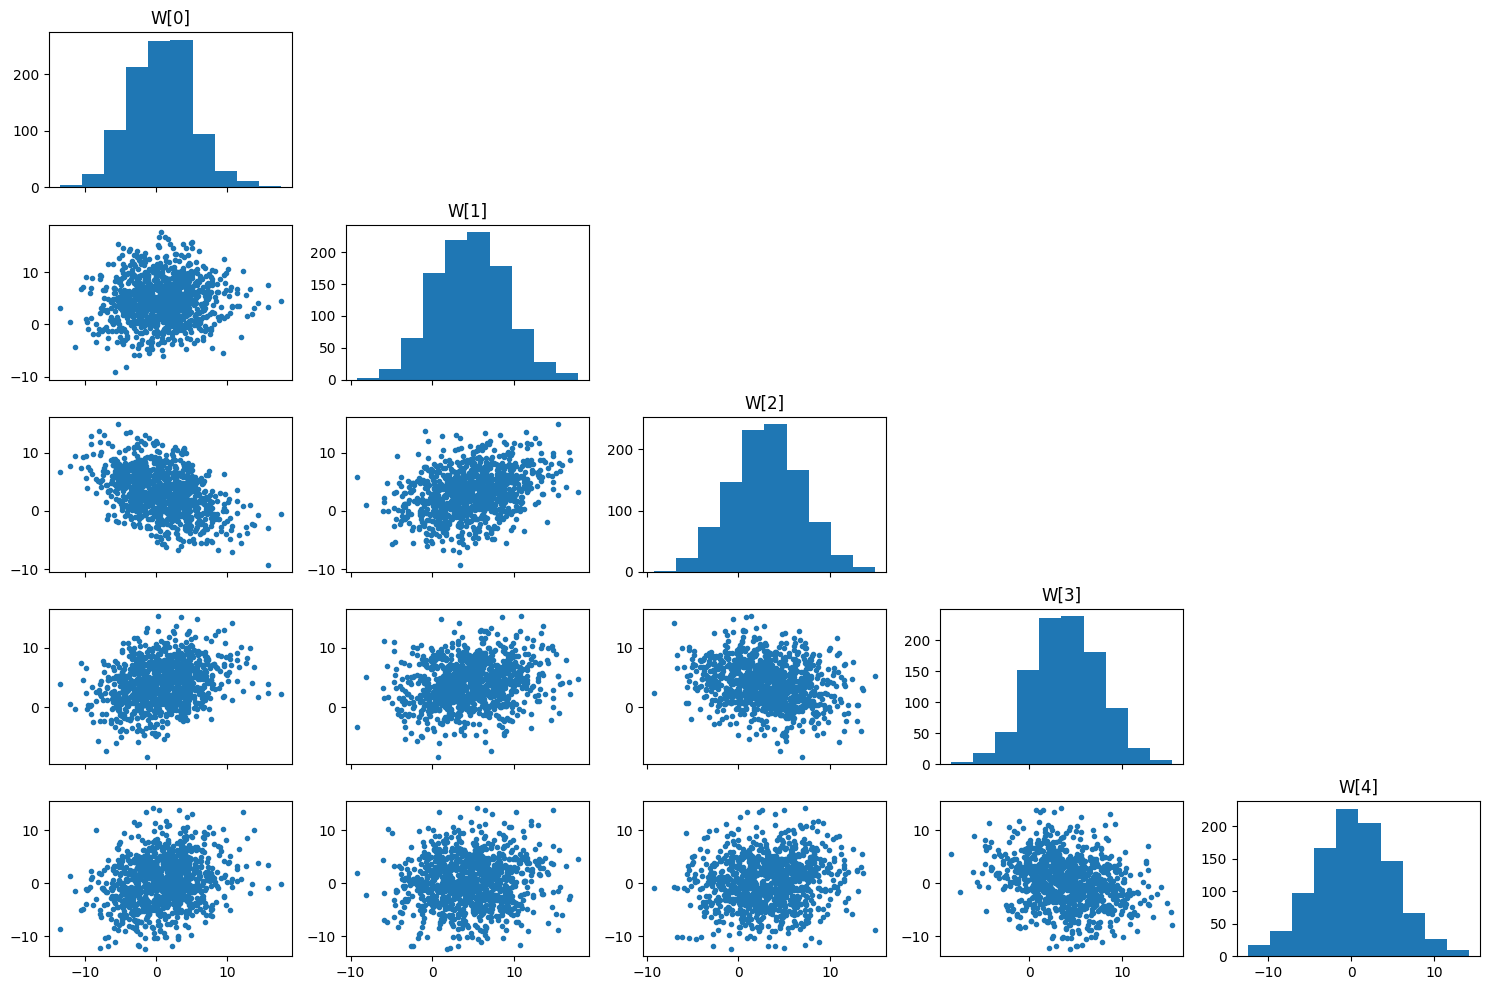

In [318]:
# fig, ax = dg.corner(samples[:, :10], save=False)
idx = np.random.permutation(np.arange(D))[:min(D, 5)]
print(idx)
fig, ax = dg.corner(samples[:, idx], save=False)

# Q family

In [79]:
# qmodel = FR_Gaussian_cov(D)
# plt.hist(qmodel.sample(1000).numpy()[:, 0], alpha=0.5)
# plt.hist(qmodel.sample(1000).numpy()[:, 1], alpha=0.5)
# plt.hist(model.sample(1000).numpy()[:, 0], alpha=0.5)
# plt.hist(model.sample(1000).numpy()[:, 1], alpha=0.5)

## Try regular optimization with forward KL to fit

In [12]:
@tf.function
def grad_norm(qmodel, model,  sample):

    sample = tf.stop_gradient(sample) * 1.
    with tf.GradientTape(persistent=True) as tape:
        tape.watch(qmodel.trainable_variables)

        with tf.GradientTape(persistent=True) as tape_in:
            tape_in.watch(sample)

            logl = model.log_likelihood(sample)
            logpr = 0. #log_prior(sample)
            logp = logl + logpr
            logq = qmodel.log_prob(sample)
            elbo = tf.reduce_mean(logq - logp, axis=0)


        grad_p = tape_in.gradient(logp, sample)
        grad_q = tape_in.gradient(logq, sample)
    
        f = tf.linalg.norm(grad_p - grad_q)
        # dotpq = tf.einsum('ij, ij -> i', grad_p, grad_q)
        # #dotqq = tf.einsum('ij, ij -> i', grad_q, grad_q)                                                                                                                                                                                                                                                                     
        # dotpp = tf.einsum('ij, ij -> i', grad_p, grad_p)
        # f = tf.reduce_mean(dotpq - dotpp)

    print('estimate grad')
    gradients = tape.gradient(f, qmodel.trainable_variables)
    return elbo, f, gradients




In [81]:
# #Test run
# qmodel = FR_Gaussian_cov(D)
# x = model.sample(4)
# model.log_likelihood(x)
# qmodel.log_prob(x)

# log_prior = lambda x: 0.
# grad_norm(qmodel, model.log_likelihood,  x);

estimate grad
0
estimate grad


2022-12-22 16:49:43.268364: W tensorflow/core/kernels/linalg/cholesky_op_gpu.cu.cc:211] Cholesky decomposition was not successful for batch 0. The input might not be valid. Filling lower-triangular output with NaNs.


50
100
150
200
250
300
350
400
450
500


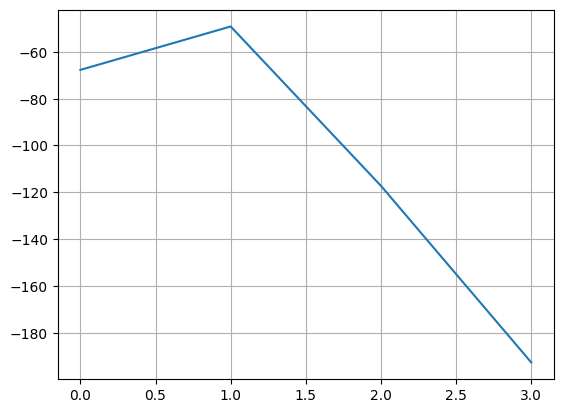

In [82]:
qmodel = FR_Gaussian_cov(D, dtype=tf.float32)
opt = tf.keras.optimizers.Adam(learning_rate=0.05)
x = model.sample(4)
grads = grad_norm(qmodel, model,  x)[2]
opt.apply_gradients(zip(grads, qmodel.trainable_variables))

niter = 500
batch_size = 1
elbos = []
for i in range(niter+1):
    if i% (niter//10) == 0: print(i)
    x = model.sample(batch_size)
    elbo, gradnorm, grads = grad_norm(qmodel, model,  x)
    opt.apply_gradients(zip(grads, qmodel.trainable_variables))
    elbos.append(elbo)
    
plt.plot(elbos)
plt.grid()

In [182]:
qmodel_batch = FR_Gaussian_cov(D, dtype=tf.float32)
opt = tf.keras.optimizers.Adam(learning_rate=0.05)

niter = 500
batch_size = 8
elbos_batch = []
for i in range(niter+1):
    if i% (niter//10) == 0: print(i)
    x = model.sample(batch_size)
    elbo, gradnorm, grads = grad_norm(qmodel_batch, model,  x)
    opt.apply_gradients(zip(grads, qmodel_batch.trainable_variables))
    elbos_batch.append(elbo)
    
plt.plot(elbos_batch)
plt.grid()

0


NameError: name 'grad_norm' is not defined

# Forward VI

In [ ]:
# tfp.bijectors.FillScaleTriL()

In [111]:
test_bijector = tfp.bijectors.FillScaleTriL()
# test_bijector.forward_dtype = dtype
# test_bijector.inverse_dtype = dtype
# test_bijector.dtype = dtype

In [113]:
# scale = 1.
# tfp.util.TransformedVariable(
#         tf.eye(D, dtype=dtype) *scale, test_bijector,
#         name="rascale_tril")


In [115]:
# qmodelfvi = gaussianq.FR_Gaussian(D, dtype=tf.float64)


In [ ]:
@tf.function
def forwardvi(qmodel, model, sample):

    # sample = tf.stop_gradient(sample)
    with tf.GradientTape(persistent=True) as tape:
        tape.watch(qmodel.trainable_variables)

        logl = model.log_likelihood(sample)
        logpr = 0. #log_prior(sample)
        logp = logl + logpr
        logq = qmodel.log_prob(sample)
        elbo = tf.reduce_mean(logq - logp)
        f = -tf.reduce_sum(logq)

    gradients = tape.gradient(f, qmodel.trainable_variables)
    return elbo, f, gradients



# qmodelfvi = FR_Gaussian_cov(D)
niter = 1000
batch_size = 8
qmodelfvi = gaussianq.FR_Gaussian(D, dtype=dtype)
opt = tf.keras.optimizers.Adam(learning_rate=0.02)
# x = qmodelfvi.sample(batch_size)
# elbo, logq, grads = forwardvi(qmodelfvi, model,  x)
# grads

elbosfvi = []
for i in range(niter+1):
    if i% (niter//10) == 0: print(i)
    x = model.sample(batch_size)
    elbo, logq, grads = forwardvi(qmodelfvi, model,  x)
    opt.apply_gradients(zip(grads, qmodelfvi.trainable_variables))
    elbosfvi.append(elbo)
    
plt.plot(elbosfvi)
plt.grid()


# Exact updates

In [85]:
# qmodel2 = FR_Gaussian_cov(D)
# x = model.sample()[0]
# v = model.grad_log_likelihood(x)
# print(x, v)

# #
# S0 = tf.constant(qmodel2.cov*1.)
# mu0 = tf.constant(qmodel2.loc*1.)
# vSv = tf.linalg.einsum('i,i->', v, tf.linalg.einsum('ij,j->i', S0, v))
# mu_v = tf.linalg.einsum('i,i->', (mu0 - x), v)
# rho = 0.5 * tf.sqrt(1 + 4*(vSv + mu_v**2)) - 0.5
# eps0 = tf.linalg.einsum('ij,j->i', S0, v) - mu0 + x

# mu_vT = tf.linalg.einsum('i,j->ij', (mu0 - x), v)
# den = 1 + rho + mu_v
# I = tf.eye(x.shape[0])
# mu_update = 1/(1 + rho) * tf.linalg.einsum('ij, j->i', ( I - mu_vT / den), eps0)
# mu = mu0 + mu_update 

# Supdate_0 =  tf.linalg.einsum('i,j-> ij', (mu0-x), (mu0-x))
# Supdate_1 =  tf.linalg.einsum('i,j-> ij', (mu-x), (mu-x))
# S_upadte = Supdate_0 - Supdate_1
# S = S0 + Supdate_0 - Supdate_1

# M0 = S0 + tf.linalg.einsum('i,j->ij', (mu0 - x), (mu0 - x))
# M0_v = tf.linalg.einsum('ij, j->i', M0, v)

# mu2 = x + M0_v / (1 + rho)
# S2 = M0 - tf.linalg.einsum('i, j->ij', M0_v, M0_v) / (1 + rho)**2


In [140]:
# @tf.function
# def gaussian_update(sample, model, qmodel):
    
    
#     logl = model.log_likelihood(sample)
#     logpr = 0.
#     logp = logl + logpr
#     logq = qmodel.log_prob(sample)
#     elbo = logq - logp
    
#     v = model.grad_log_likelihood(sample)
#     S0 = qmodel.cov*1.
#     mu0 = qmodel.loc*1.
#     # S0 = tf.constant(qmodel.cov*1.)
#     # mu0 = tf.constant(qmodel.loc*1.)
    
#     #intermediate varaibles
#     vSv = tf.linalg.einsum('i,i->', v, tf.linalg.einsum('ij,j->i', S0, v))
#     mu_v = tf.linalg.einsum('i,i->', (mu0 - sample), v)
#     rho = 0.5 * tf.sqrt(1 + 4*(vSv + mu_v**2)) - 0.5
#     eps0 = tf.linalg.einsum('ij,j->i', S0, v) - mu0 + sample
    
#     M0 = S0 + tf.linalg.einsum('i,j->ij', (mu0 - sample), (mu0 - sample))
#     M0_v = tf.linalg.einsum('ij, j->i', M0, v)
#     M0_v_update = tf.linalg.einsum('i, j->ij', M0_v, M0_v) 
    
#     mu = sample + M0_v / (1 + rho)
#     S = M0 -  M0_v_update/ (1 + rho)**2 #+ tf.linalg.eye(S0.shape[0], dtype=dtype)*1e-5
    
#     #Update distribution
#     qmodel.loc.assign(mu)
#     qmodel.cov.assign(S)
    
#     return elbo

In [320]:
@tf.function
def gaussian_update(sample, model, qmodel):
    
    logl = model.log_likelihood(sample)
    logpr = 0.
    logp = logl + logpr
    logq = qmodel.log_prob(sample)
    elbo = logq - logp
    
    v = model.grad_log_likelihood(sample)
    S0 = tf.identity(qmodel.cov)
    mu0 = tf.identity(qmodel.loc*1.)
    
    #intermediate varaibles
    vSv = tf.linalg.einsum('i,i->', v, tf.linalg.einsum('ij,j->i', S0, v))
    mu_v = tf.linalg.einsum('i,i->', (mu0 - sample), v)
    rho = 0.5 * tf.sqrt(1 + 4*(vSv + mu_v**2)) - 0.5
    eps0 = tf.linalg.einsum('ij,j->i', S0, v) - mu0 + sample
    
    #mu update
    mu_vT = tf.linalg.einsum('i,j->ij', (mu0 - sample), v)
    den = 1 + rho + mu_v
    I = tf.eye(sample.shape[0], dtype=dtype)
    mu_update = 1/(1 + rho) * tf.linalg.einsum('ij, j->i', ( I - mu_vT / den), eps0)
    mu = mu0 + mu_update 

    #S update
    Supdate_0 =  tf.linalg.einsum('i,j-> ij', (mu0-sample), (mu0-sample))
    Supdate_1 =  tf.linalg.einsum('i,j-> ij', (mu-sample), (mu-sample))
    Supdate = (Supdate_0 - Supdate_1 ) #+ tf.linalg.eye(S0.shape[0], dtype=dtype)*0)
    S = S0 + Supdate
    
  
    #Update distribution
    qmodel.loc.assign(mu)
    qmodel.cov.assign(S)
    
    return elbo

 

In [321]:
@tf.function
def get_update(sample, v, mu0, S0):
    vSv = tf.linalg.einsum('i,i->', v, tf.linalg.einsum('ij,j->i', S0, v))
    mu_v = tf.linalg.einsum('i,i->', (mu0 - sample), v)
    rho = 0.5 * tf.sqrt(1 + 4*(vSv + mu_v**2)) - 0.5
    eps0 = tf.linalg.einsum('ij,j->i', S0, v) - mu0 + sample

    #mu update
    mu_vT = tf.linalg.einsum('i,j->ij', (mu0 - sample), v)
    den = 1 + rho + mu_v
    I = tf.eye(sample.shape[0], dtype=dtype)
    mu_update = 1/(1 + rho) * tf.linalg.einsum('ij, j->i', ( I - mu_vT / den), eps0)
    mu = mu0 + mu_update

    #S update
    Supdate_0 =  tf.linalg.einsum('i,j-> ij', (mu0-sample), (mu0-sample))
    Supdate_1 =  tf.linalg.einsum('i,j-> ij', (mu-sample), (mu-sample))
    S_update = (Supdate_0 - Supdate_1)
    # S_update = (Supdate_0 - Supdate_1 + tf.linalg.eye(S0.shape[0], dtype=dtype)*0.)
    return mu_update, S_update



@tf.function
def gaussian_update_batch(samples, model, qmodel):
    
    
    logl = model.log_likelihood(samples[0])
    logpr = 0.
    logp = logl + logpr
    logq = qmodel.log_prob(samples[0])
    elbo = logq - logp
    
    S0 = tf.identity(qmodel.cov)
    mu0 = tf.identity(qmodel.loc*1.)
    
    #intermediate varaibles
    mu_updates, S_updates = [], []
    for i in range(len(samples)):
        sample = samples[i]
        v = model.grad_log_likelihood(sample)
        mu_update, S_update = get_update(sample, v, mu0, S0)
        mu_updates.append(mu_update)
        S_updates.append(S_update)
        
    mu_update = tf.reduce_mean(tf.stack(mu_updates, axis=0), axis=0)
    S_update = tf.reduce_mean(tf.stack(S_updates, axis=0), axis=0)
    mu = mu0 + mu_update
    S = S0 + S_update
    
    #Update distribution
    qmodel.loc.assign(mu)
    qmodel.cov.assign(S)
    
    return elbo




In [322]:
@tf.function
def get_mu_update(sample, v, mu0, S0):
    vSv = tf.linalg.einsum('i,i->', v, tf.linalg.einsum('ij,j->i', S0, v))
    mu_v = tf.linalg.einsum('i,i->', (mu0 - sample), v)
    rho = 0.5 * tf.sqrt(1 + 4*(vSv + mu_v**2)) - 0.5
    eps0 = tf.linalg.einsum('ij,j->i', S0, v) - mu0 + sample

    #mu update
    mu_vT = tf.linalg.einsum('i,j->ij', (mu0 - sample), v)
    den = 1 + rho + mu_v
    I = tf.eye(sample.shape[0], dtype=dtype)
    mu_update = 1/(1 + rho) * tf.linalg.einsum('ij, j->i', ( I - mu_vT / den), eps0)
    
    return mu_update

@tf.function
def get_S_update(sample, mu0, mu):
    #S update
    Supdate_0 =  tf.linalg.einsum('i,j-> ij', (mu0-sample), (mu0-sample))
    Supdate_1 =  tf.linalg.einsum('i,j-> ij', (mu-sample), (mu-sample))
    S_update = (Supdate_0 - Supdate_1)
    return S_update



@tf.function
def gaussian_update_batch2(samples, model, qmodel):
    
    
    logl = model.log_likelihood(samples[0])
    logpr = 0.
    logp = logl + logpr
    logq = qmodel.log_prob(samples[0])
    elbo = logq - logp
    
    S0 = tf.identity(qmodel.cov)
    mu0 = tf.identity(qmodel.loc*1.)
    
    #update mu
    mu_updates = []
    for i in range(len(samples)):
        sample = samples[i]
        v = model.grad_log_likelihood(sample)
        mu_update = get_mu_update(sample, v, mu0, S0)
        mu_updates.append(mu_update)
        
    mu_update = tf.reduce_mean(tf.stack(mu_updates, axis=0), axis=0)
    mu = mu0 + mu_update
    
    #update S
    S_updates = []
    for i in range(len(samples)):
        sample = samples[i]
        S_update = get_S_update(sample, mu0, mu)
        S_updates.append(S_update)
    S_update = tf.reduce_mean(tf.stack(S_updates, axis=0), axis=0)
    S = S0 + S_update
    
    #Update distribution
    qmodel.loc.assign(mu)
    qmodel.cov.assign(S)
    
    return elbo




0
100
200
300
400
500
600
700
800
900
1000


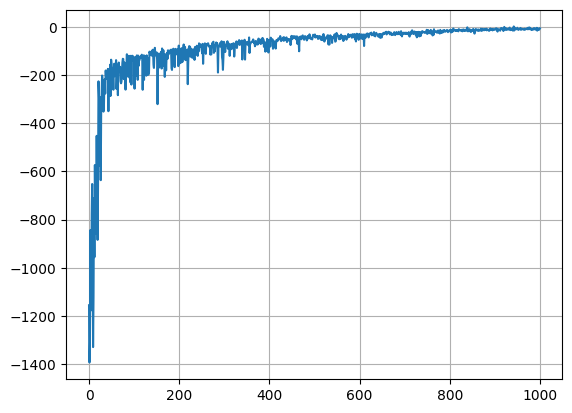

In [323]:

qmodel_exact = FR_Gaussian_cov(D, dtype=dtype)
elbos_exact = []

niter = 1000
for i in range(niter + 1):
    if i% (niter//10) == 0: print(i)
    x = model.sample()[0]
    elbo = gaussian_update(x, model, qmodel_exact)
    
    # x = list(model.sample(8))
    # elbo = gaussian_update_batch(x, model, qmodel_exact)

    # x = list(model.sample(1))
    # elbo = gaussian_update_batch2(x, model, qmodel_exact)
    
    if np.linalg.eigvals(qmodel_exact.cov).min() < 0:
        print(np.linalg.eigvals(qmodel_exact.cov))
        break
    elbos_exact.append(elbo)

plt.plot(elbos_exact)
plt.grid()


In [276]:
# # elbo = gaussian_update(x, model, qmodel_exact)
# sample = x*1.

# v = model.grad_log_likelihood(sample)
# S0 = tf.identity(qmodel_exact.cov)
# mu0 = tf.identity(qmodel_exact.loc)
# #
# vSv = tf.linalg.einsum('i,i->', v, tf.linalg.einsum('ij,j->i', S0, v))
# mu_v = tf.linalg.einsum('i,i->', (mu0 - x), v)
# rho = 0.5 * tf.sqrt(1 + 4*(vSv + mu_v**2)) - 0.5
# print(rho)
# eps0 = tf.linalg.einsum('ij,j->i', S0, v) - mu0 + x
# print(eps0)


# M0 = S0 + tf.linalg.einsum('i,j->ij', (mu0 - sample), (mu0 - sample))
# M0_v = tf.linalg.einsum('ij, j->i', M0, v)
# M0_v_update = tf.linalg.einsum('i, j->ij', M0_v, M0_v)
# M0_v_update64 = np.outer(M0_v.numpy().astype(float64), M0_v.numpy().astype(float64))

# S = M0 -  M0_v_update/ (1 + rho)**2 #+ tf.linalg.eye(M0.shape[0])*1e-5

# M0_v_update;

# np.linalg.eigvals(qmodel_exact.cov)
# np.linalg.eigvals(S0)
# # np.linalg.eigvals(M0_v_update)
# # np.linalg.eigvals(np.eye(D)*1e-5  + M0_v_update64)

In [277]:
# plt.plot(np.linalg.eigvals(S0), marker='o')
# plt.plot(np.linalg.eigvals(M0), marker='o')
# plt.plot(np.linalg.eigvals(S), marker='x', alpha=0.5)
# plt.axhline(0, color='k')
# plt.yscale('log')

[]

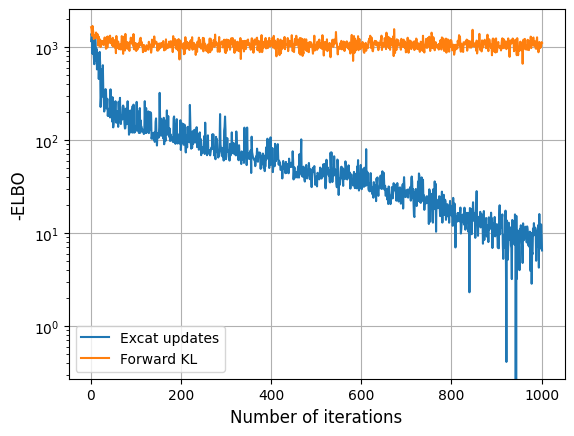

In [324]:
# plt.plot(np.arange(len(elbos))+1, -np.array(elbos), label='Score matching, ADAM')
# plt.plot(np.arange(len(elbos_batch))+1, -np.array(elbos_batch), label='Score matching, ADAM, Batch 8')
plt.plot(np.arange(len(elbos_exact))+1, -np.array(elbos_exact), label='Excat updates')
plt.plot(np.arange(len(elbosfvi))+1, -np.array(elbosfvi), label='Forward KL')
# plt.grid(which='both')
plt.grid()
plt.xlabel('Number of iterations', fontsize=12)
plt.ylabel('-ELBO', fontsize=12)
plt.legend()
plt.semilogy()
# plt.savefig('elbo_D10.png')

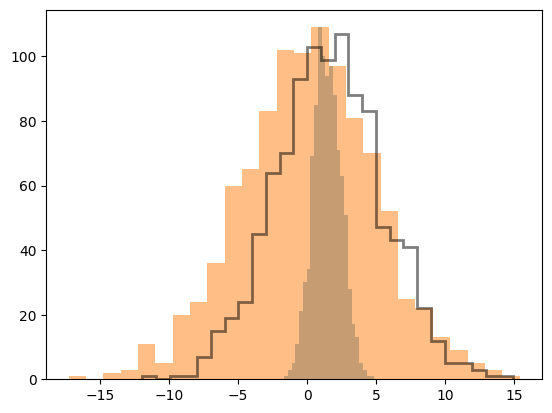

In [325]:
ii = np.random.randint(D)
# plt.hist(qmodel.sample(1000).numpy()[:, ii], alpha=0.5, color='C0', histtype='step', lw=2, ls="--", bins='auto')
# plt.hist(qmodel_batch.sample(1000).numpy()[:, ii], alpha=0.5, color='C0', bins='auto')
plt.hist(qmodelfvi.sample(1000).numpy()[:, ii], alpha=0.5, color='C0', bins='auto')
plt.hist(qmodel_exact.sample(1000).numpy()[:, ii], alpha=0.5, color='C1', bins='auto')
plt.hist(model.sample(1000).numpy()[:, ii], alpha=0.5, color='k', histtype='step', lw=2, bins='auto');


[55 65 98 99 47]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


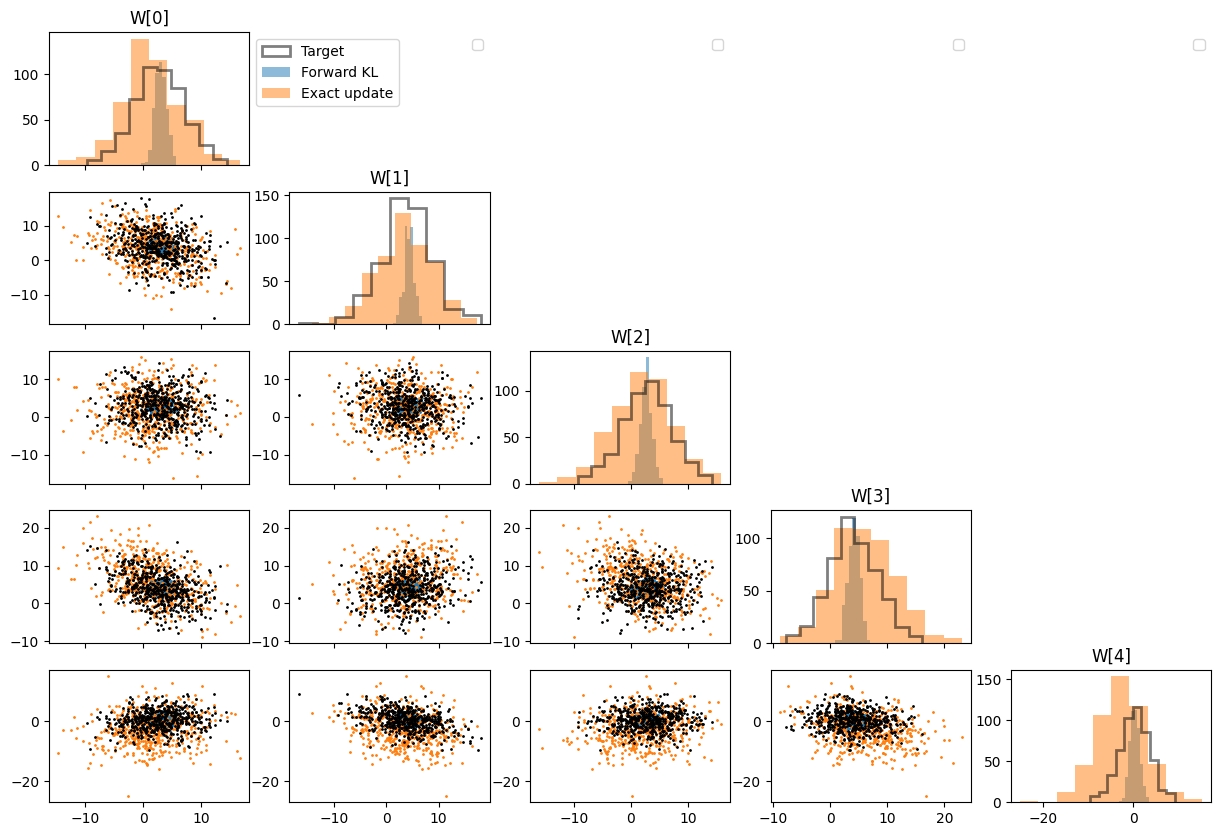

In [326]:
Dplot = min(5, D)
idx = np.random.permutation(np.arange(D))[:min(D, Dplot)]
print(idx)

# qsamples = qmodel.sample(1000).numpy()[:, idx]
# qsamples_batch = qmodel_batch.sample(1000).numpy()[:, idx]
qsamples_exact = qmodel_exact.sample(500).numpy()[:, idx]
qsamplesfvi = qmodelfvi.sample(500).numpy()[:, idx]
samplesidx = samples[:500, idx]


fig, ax = plt.subplots(Dplot, Dplot, figsize=(3*Dplot, 2*Dplot), sharex='col')

for i in range(Dplot):
    for j in range(Dplot):
    
        if i==j:
            if i == 0:
                lbl0 = "Target"
                lbl1 = "Score matching"
                lbl1b = "Score matching"
                lbl2 = "Exact update"
                lbl3 = "Forward KL"
            else:
                lbl0, lbl1, lbl2, lbl3 = [None]*4
            ax[i, j].hist(samplesidx[:, i], color='k', alpha=0.5, histtype='step', lw=2 ,label=lbl0)
            # ax[i, j].hist(qsamples[:, i], alpha=0.5,label=lbl1)
            # ax[i, j].hist(qsamples_batch[:, i], alpha=0.5,label=lbl1b)
            ax[i, j].hist(qsamplesfvi[:, i], alpha=0.5,label=lbl3)
            ax[i, j].hist(qsamples_exact[:, i], alpha=0.5,label=lbl2)
            ax[i, j].set_title('W[{}]'.format(i))
        elif i>j:
            # ax[i, j].plot(samplesidx[:, j], samplesidx[:, i], 'k.', markersize=1)
            # ax[i, j].plot(qsamples[:, j], qsamples[:, i], '.')
            # ax[i, j].plot(qsamples_batch[:, j], qsamples_batch[:, i], '.')
            ax[i, j].plot(qsamplesfvi[:, j], qsamplesfvi[:, i], '.', markersize=2)
            ax[i, j].plot(qsamples_exact[:, j], qsamples_exact[:, i], '.', markersize=2)
            ax[i, j].plot(samplesidx[:, j], samplesidx[:, i], 'k.', markersize=2)
        else:
            ax[i, j].axis('off')
        if i == 0: ax[i, j].legend(bbox_to_anchor=(1, 1))
# plt.tight_layout()
# plt.savefig('posterior_D10.png')

# Sample from the distribution

In [ ]:

qmodel_test = FR_Gaussian_cov(D, scale=5, dtype=dtype)
elbos_test = []

niter = 5000 
for i in range(niter + 1):
    if i% (niter//10) == 0: print(i)

    # x = qmodel_test.sample()[0]*1.
    # elbo = gaussian_update(x, model, qmodel_test)

    x = list(qmodel_test.sample(8))
    elbo = gaussian_update_batch(x, model, qmodel_test)
    
    if elbo == -1: 
        print("Failed at iteration : ", i)
        break
    elbos_test.append(elbo)

plt.plot(elbos_test)
plt.loglog()
plt.grid()

0
500
1000
1500
2000


In [ ]:
# elbo = gaussian_update(x, model, qmodel_test)
# sample = x*1.

# v = model.grad_log_likelihood(sample)
# S0 = qmodel_test.cov*1.
# mu0 = qmodel_test.loc*1.

# M0 = S0 + tf.linalg.einsum('i,j->ij', (mu0 - sample), (mu0 - sample))
# M0_v = tf.linalg.einsum('ij, j->i', M0, v)
# M0_v_update = tf.linalg.einsum('i, j->ij', M0_v, M0_v)
# # M0_v_update = tf.linalg.einsum('i, j->ij', M0_v, M0_v)
# M0_v_update64 = np.outer(M0_v.numpy().astype(float64), M0_v.numpy().astype(float64))

# M0_v_update

# np.linalg.eigvals(M0_v_update64)
# np.linalg.eigvals(np.eye(D)*1e-5  + M0_v_update64)

In [ ]:
# plt.plot(np.arange(len(elbos))+1, -np.array(elbos), label='Score matching, ADAM')
# plt.plot(np.arange(len(elbos_batch))+1, -np.array(elbos_batch), label='Score matching, ADAM, Batch 8', alpha=0.5)
plt.plot(np.arange(len(elbos_exact))+1, -np.array(elbos_exact), label='Exact updates', alpha=0.5)
plt.plot(np.arange(len(elbosfvi))+1, -np.array(elbosfvi), label='Forward KL', alpha=0.5)
plt.plot(np.arange(len(elbos_test))+1, -np.array(elbos_test), label='Exact test updates', alpha=0.5)
# plt.grid(which='both')
plt.grid()
plt.xlabel('Number of iterations', fontsize=12)
plt.ylabel('-ELBO', fontsize=12)
plt.legend()
# plt.semilogy()
# plt.savefig('elbo_D10.png')

In [ ]:
Dplot = min(5, D)
idx = np.random.permutation(np.arange(D))[:min(D, Dplot)]
print(idx)

nsamples = 500 
qsamples_exact = qmodel_exact.sample(nsamples).numpy()[:, idx]
qsamplesfvi = qmodelfvi.sample(nsamples).numpy()[:, idx]
samplesidx = samples[:nsamples, idx]
qsamples_test = qmodel_test.sample(nsamples).numpy()[:, idx]


fig, ax = plt.subplots(Dplot, Dplot, figsize=(3*Dplot, 2*Dplot), sharex='col')

for i in range(Dplot):
    for j in range(Dplot):
    
        if i==j:
            if i == 0:
                lbl0 = "Target"
                lbl1 = "Score matching"
                lbl1b = "Score matching"
                lbl2 = "Exact update"
                lbl2b = "Exact update Qsample"
                lbl3 = "Forward KL"
            else:
                lbl0, lbl1, lbl2, lbl3 = [None]*4
            ax[i, j].hist(qsamplesfvi[:, i], alpha=0.5,label=lbl3)
            ax[i, j].hist(qsamples_exact[:, i], alpha=0.5,label=lbl2)
            ax[i, j].hist(qsamples_test[:, i], alpha=0.5,label=lbl2b)
            ax[i, j].hist(samplesidx[:, i], color='k', alpha=0.5, histtype='step', lw=2 ,label=lbl0)
            ax[i, j].set_title('W[{}]'.format(i))
        elif i>j:
            ax[i, j].plot(qsamplesfvi[:, j], qsamplesfvi[:, i], '.', markersize=2)
            ax[i, j].plot(qsamples_exact[:, j], qsamples_exact[:, i], '.', markersize=2)
            ax[i, j].plot(qsamples_test[:, j], qsamples_test[:, i], '.', markersize=2)
            ax[i, j].plot(samplesidx[:, j], samplesidx[:, i], 'k.', markersize=2)
        else:
            ax[i, j].axis('off')
        if i == 0: ax[i, j].legend(bbox_to_anchor=(1, 1))
# plt.tight_layout()
# plt.savefig('posterior_D10.png')